In [ ]:
!pip install -q -U albumentations

from torch.utils.data import DataLoader, ConcatDataset
import torch 
import torch.nn.functional as F
import torchvision 
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os 
import matplotlib.pyplot as plt 
from google.colab import drive, files
import numpy as np
from dataset import Carla
from unet import UNet

drive.mount("/content/gdrive")

print(torch.cuda.is_available())

     |████████████████████████████████| 102 kB 6.3 MB/s 
     |████████████████████████████████| 47.6 MB 68 kB/s 
Mounted at /content/gdrive
True


In [ ]:
test_transforms = A.Compose([
          A.augmentations.geometric.resize.Resize(150,200),
          ToTensorV2()
])
DEVICE = 'cuda'
DATASET_PATH = 'gdrive/MyDrive/dataset/'
SAVE_PATH = 'gdrive/MyDrive/models/'
TEST_LOADER = Carla(DATASET_PATH + 'dataC/dataC/', transform = test_transforms)
TEST_DATASET = DataLoader(dataset = TEST_LOADER, batch_size = 32, shuffle = True, drop_last = True)
MODEL = UNet(3,13).to(device=DEVICE)
MODEL.load_state_dict(torch.load(SAVE_PATH + 'BEST_MODEL' + '.pth')['state_dict'])

<All keys matched successfully>

In [ ]:
x,y = next(iter(TEST_DATASET))
MODEL.eval()
output = MODEL(x.reshape(32,3,150,200).to(device=DEVICE))
o = output.argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
def class2rg(out):
  classes = {
    0 : [0,0,0], # unlabeled
    1 : [70,70,70], # building
    2 : [190,153,153], # fence
    3 : [250,170,160], # other
    4 : [220,20,60], # pedestrian
    5 : [153,153,153], # pole
    6 : [157,234,50], # road line
    7 : [128,64,128], # road
    8 : [244,35,232], # sidewalk
    9 : [107,142,35], # vegetation
    10: [0,0,142], # car
    11: [102,102,156], # wall
    12: [220,220,0] # traffic sign
  }
  o = out
  seg = o.reshape(-1)
  mask = np.zeros((150*200,3))
  

  for idx, label in enumerate(seg):
    mask[idx] = classes[int(label)]

  return mask.reshape(150,200,3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


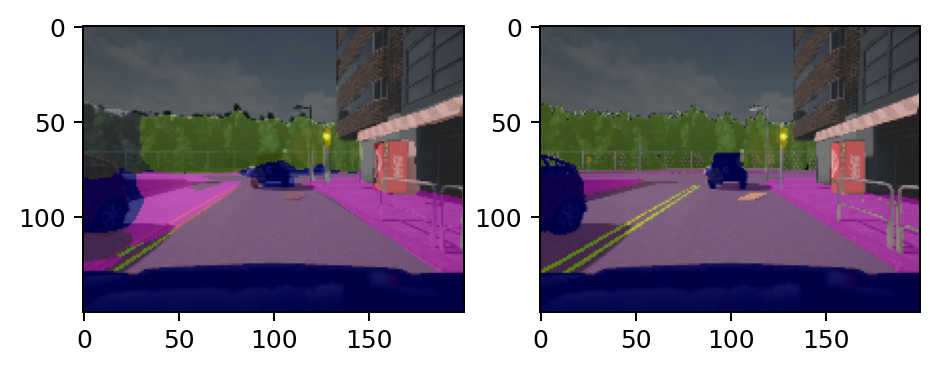

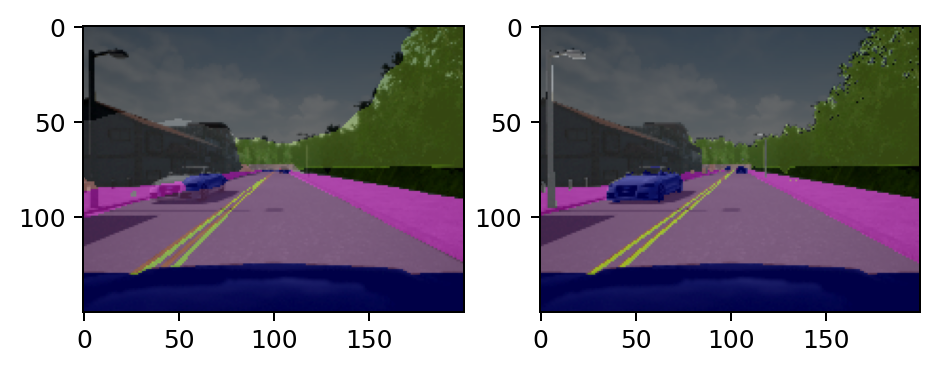

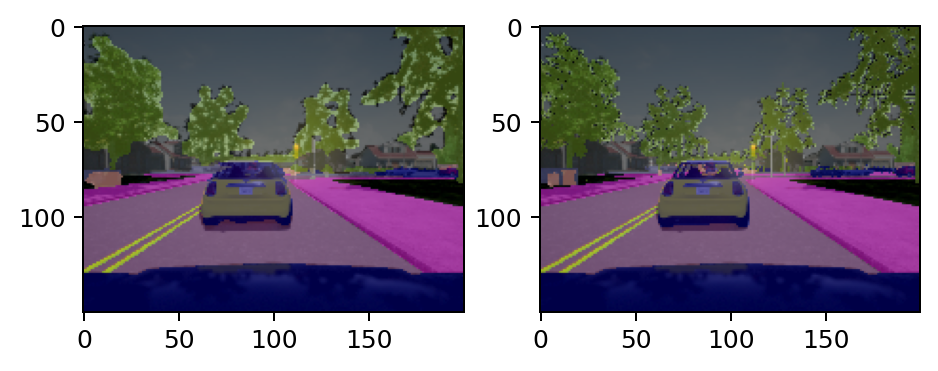

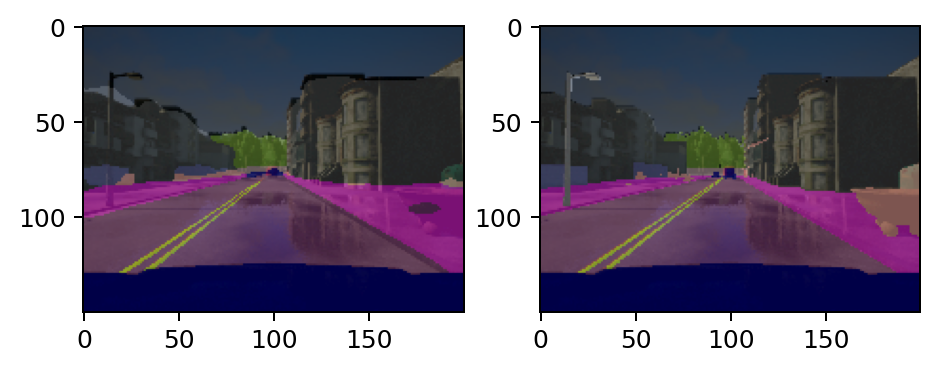

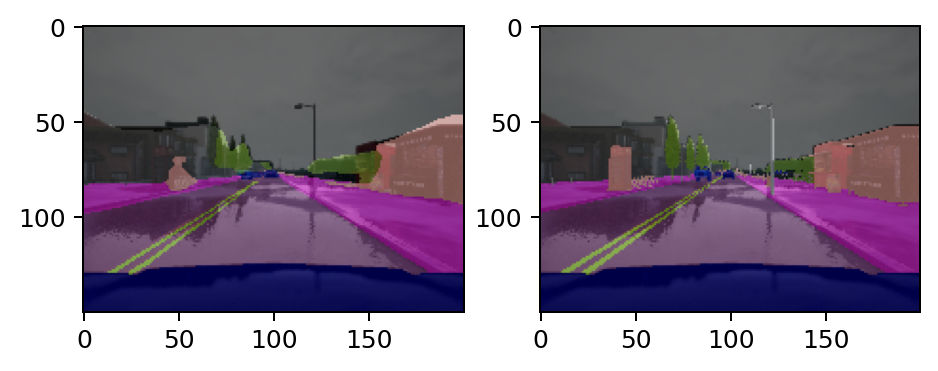

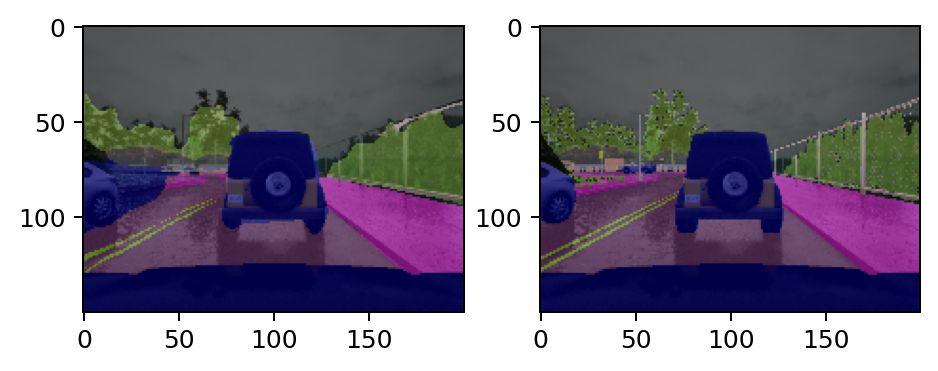

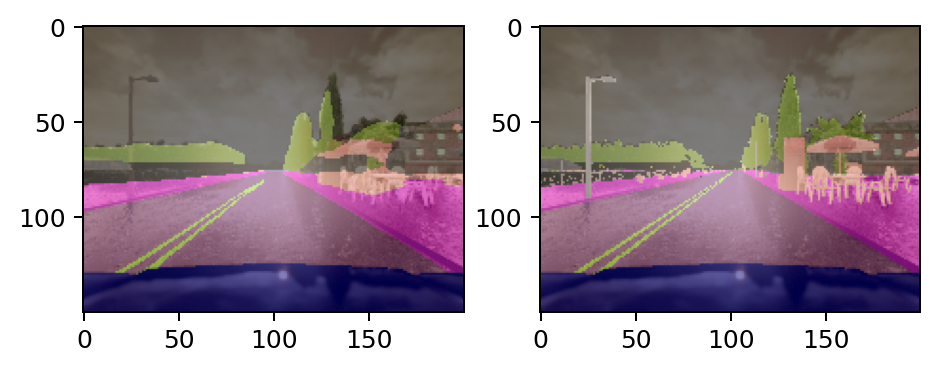

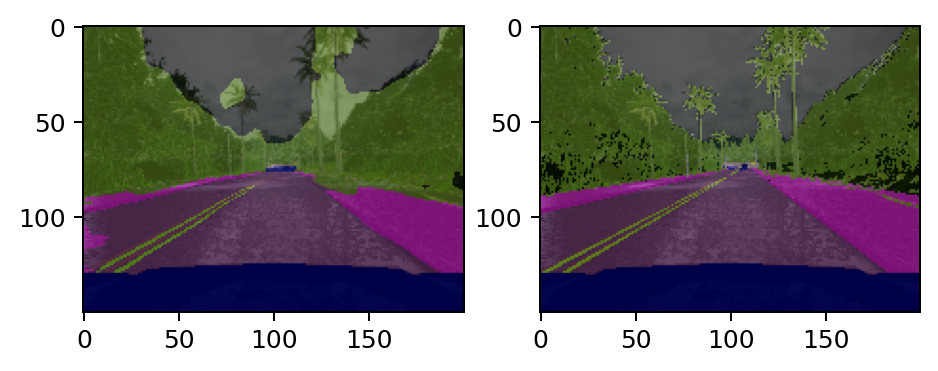

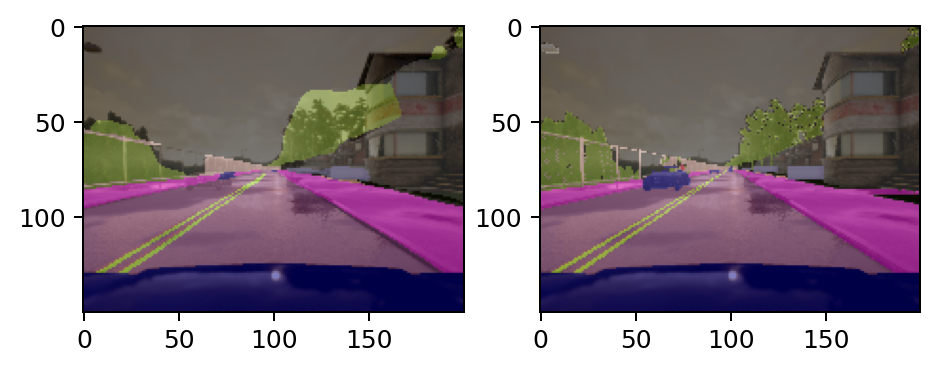

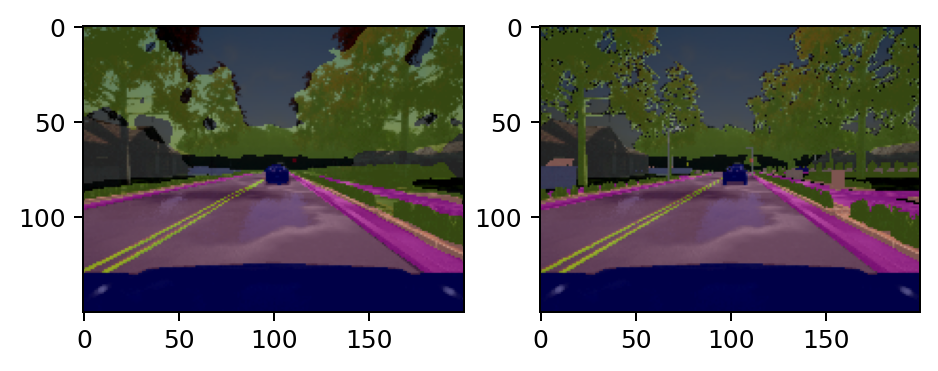

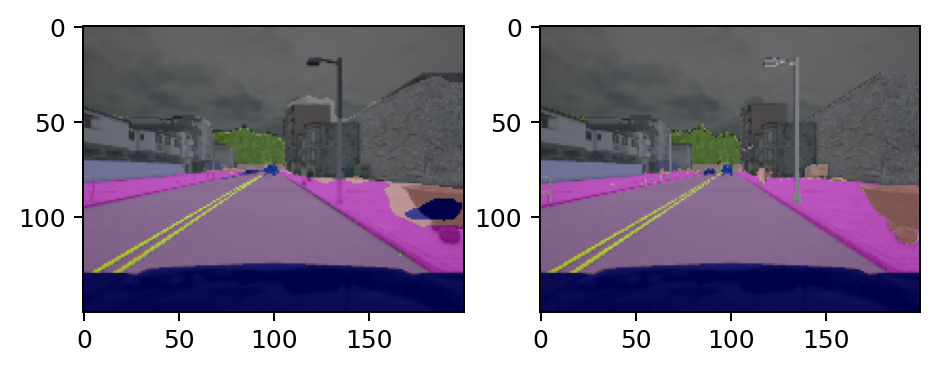

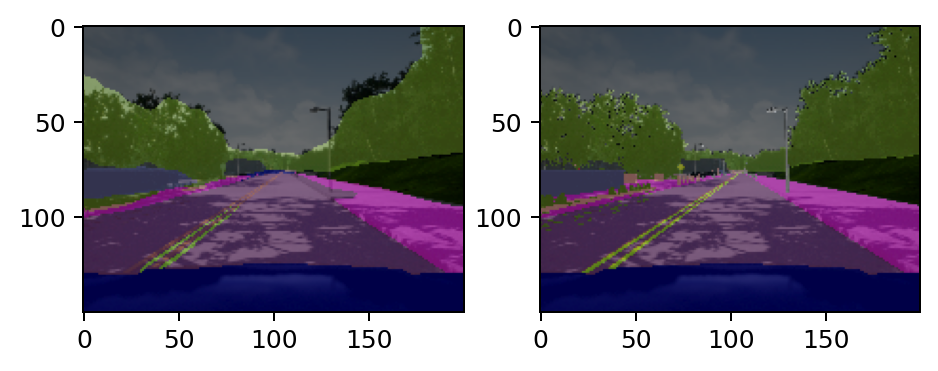

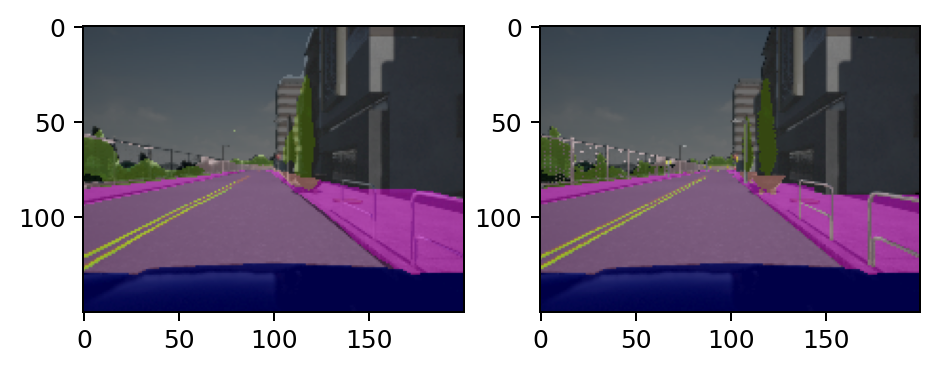

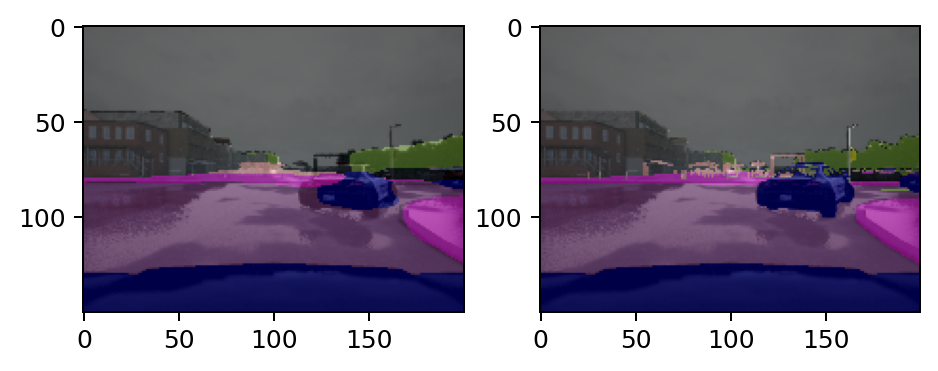

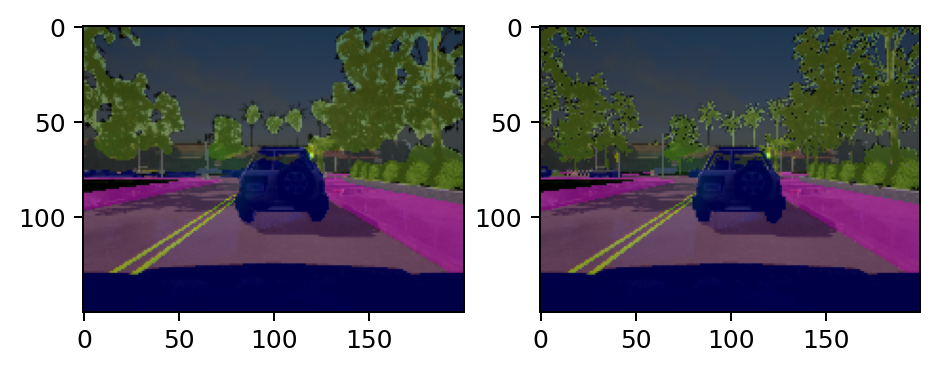

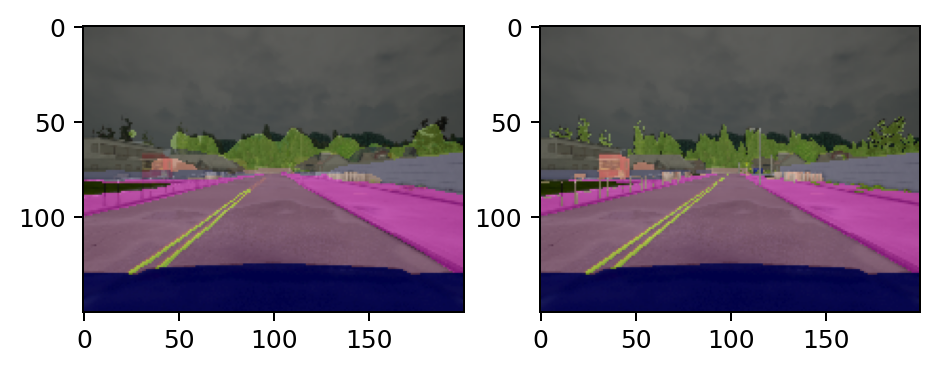

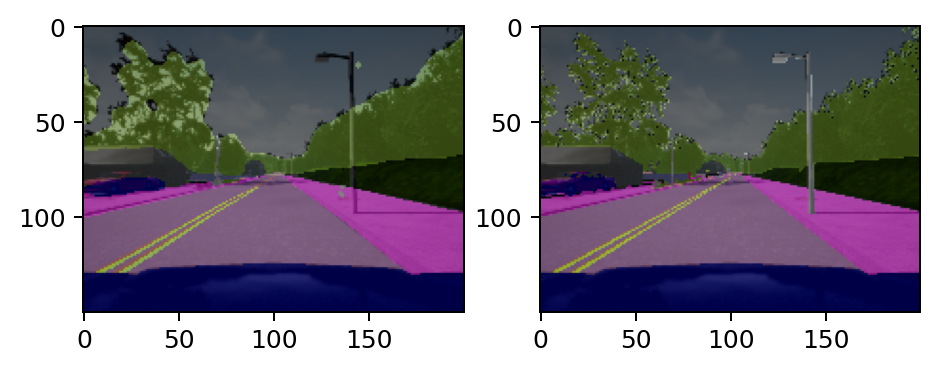

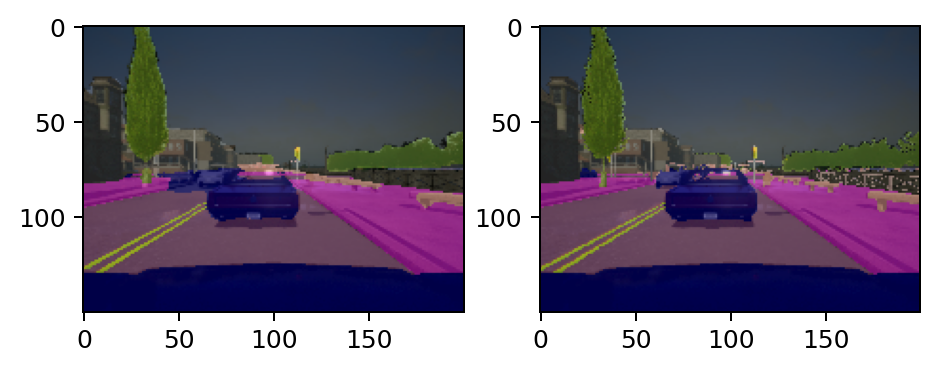

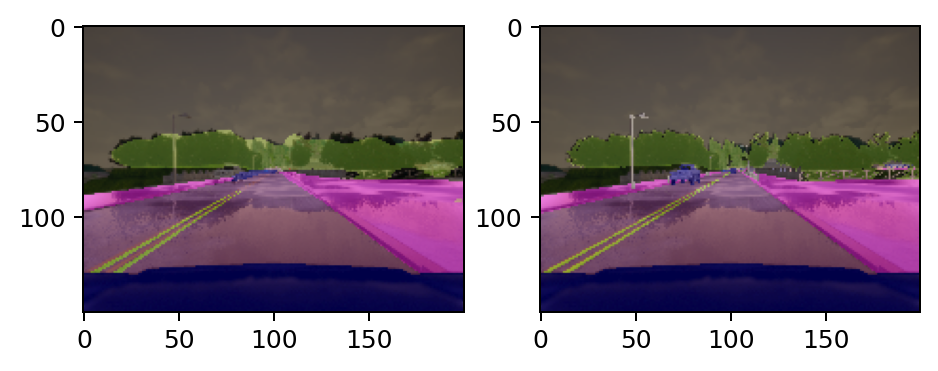

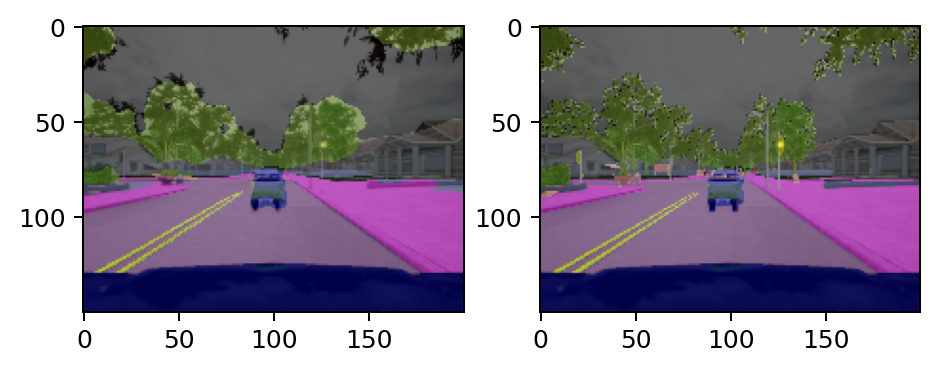

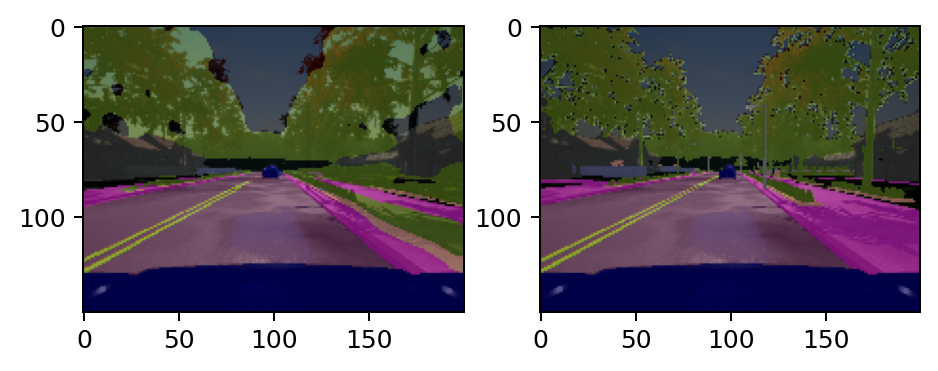

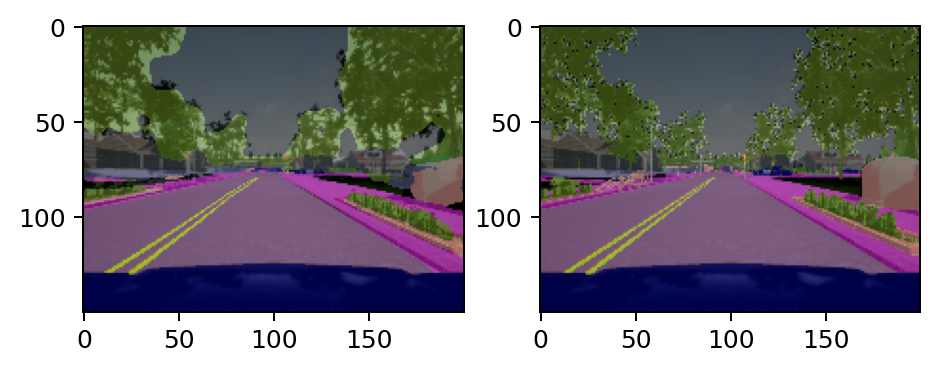

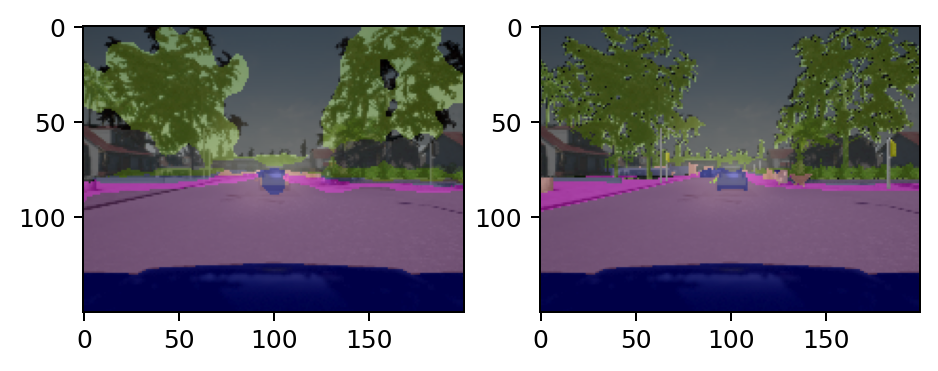

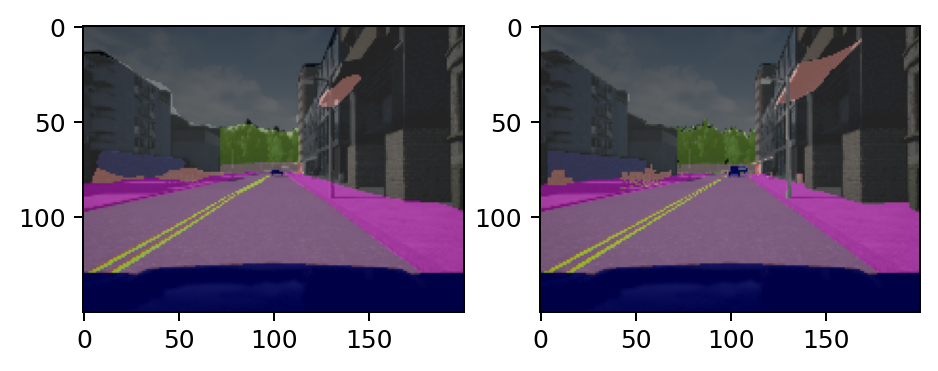

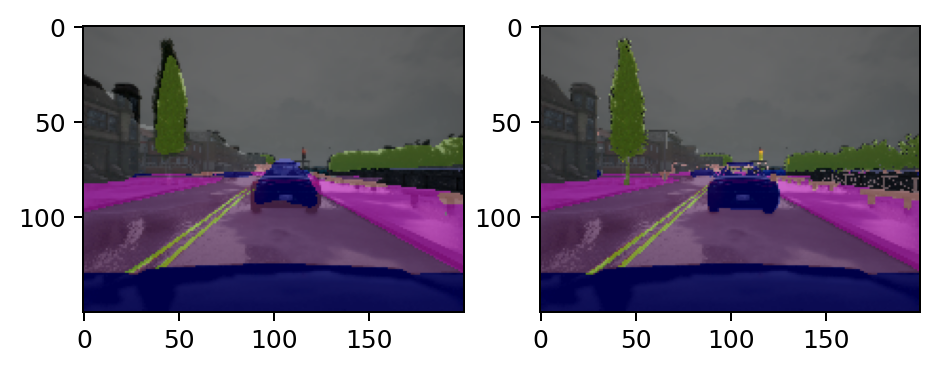

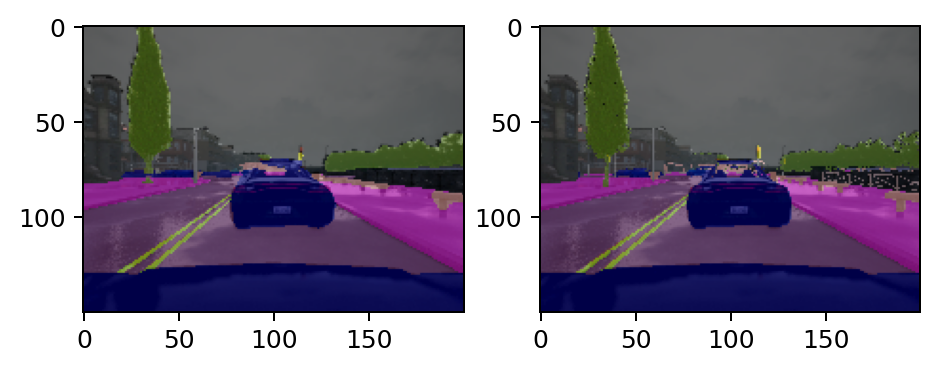

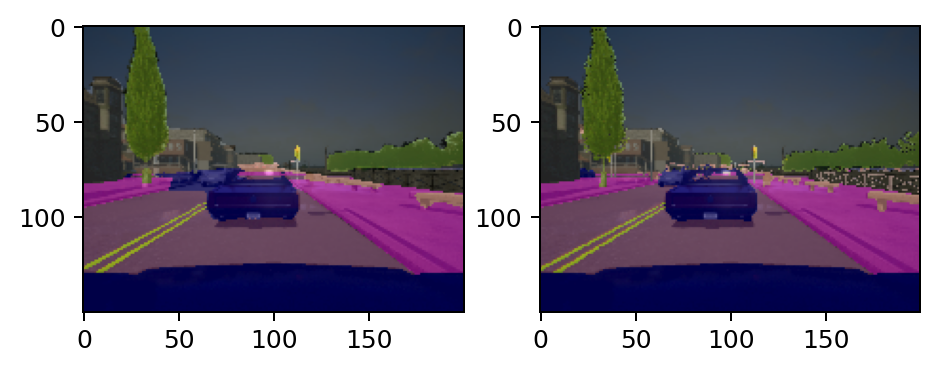

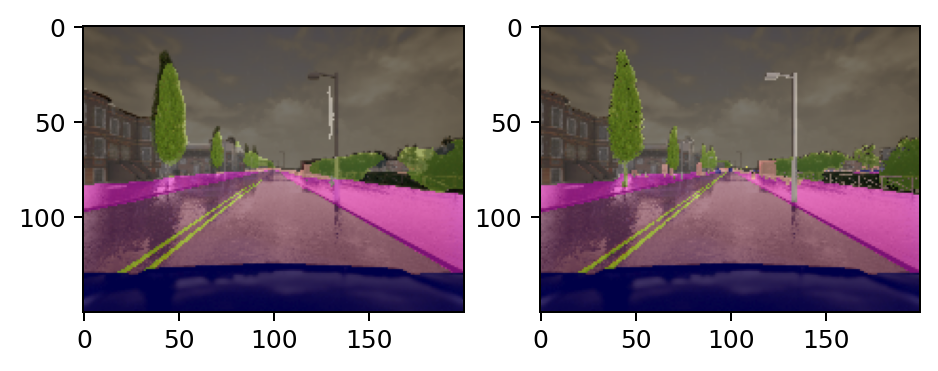

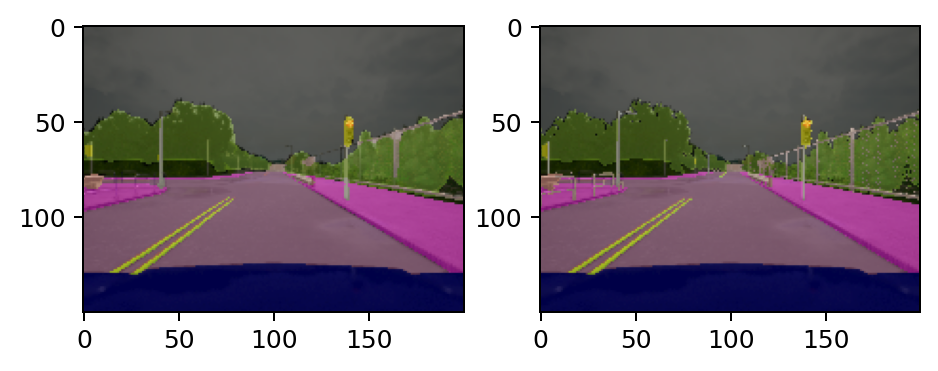

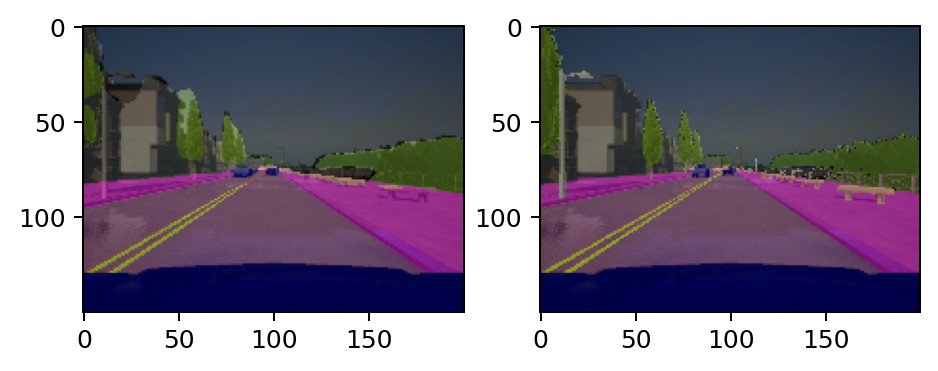

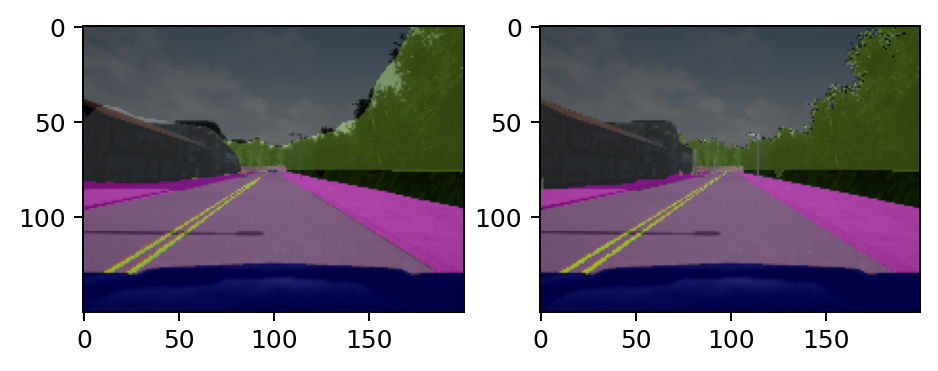

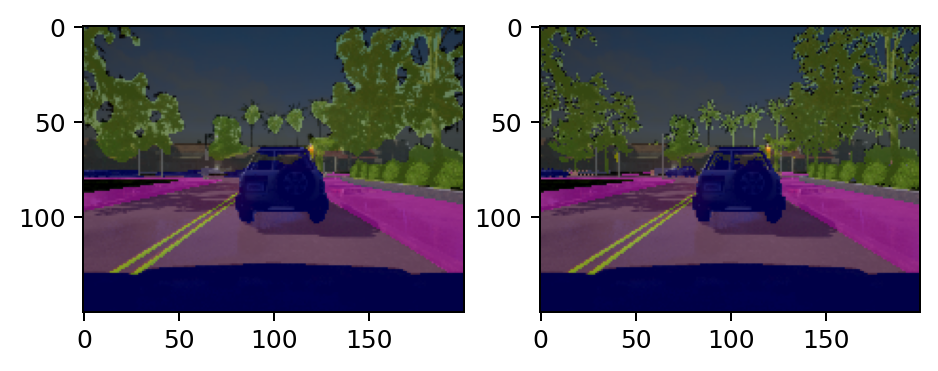

In [ ]:
imgs = []
for i in range(x.shape[0]):

  plt.figure(dpi = 180)
  plt.subplot(121)
  img_x = np.int64(x[i].cpu().numpy() * 255)
  img_o = np.int64(class2rg(output[i].argmax(0).cpu().numpy()))
  combo1 = (img_x + img_o)//2
  plt.imshow(combo1)
  plt.subplot(122)
  img_y = np.int64(class2rg(y[i][...,0].cpu()))
  combo2 = (img_x + img_y)//2
  plt.imshow(combo2)
  imgs.append(combo1)
  imgs.append(combo2)


In [ ]:
imgs = imgs[::-1]

In [ ]:
def rows(img, size = 4):
  row = img[0]
  for i in range(size-1):
    row = np.hstack((row,img[i+1]))
  return row

def cols(imgs, size = 4):
  col = imgs[0]
  for i in range(size-1):
    col = np.vstack((col,imgs[i+1]))
  return col 

ROWS = []
for i in range(0,16,4):
  ROWS.append(rows(imgs[i:i+4]))
res = cols(ROWS)

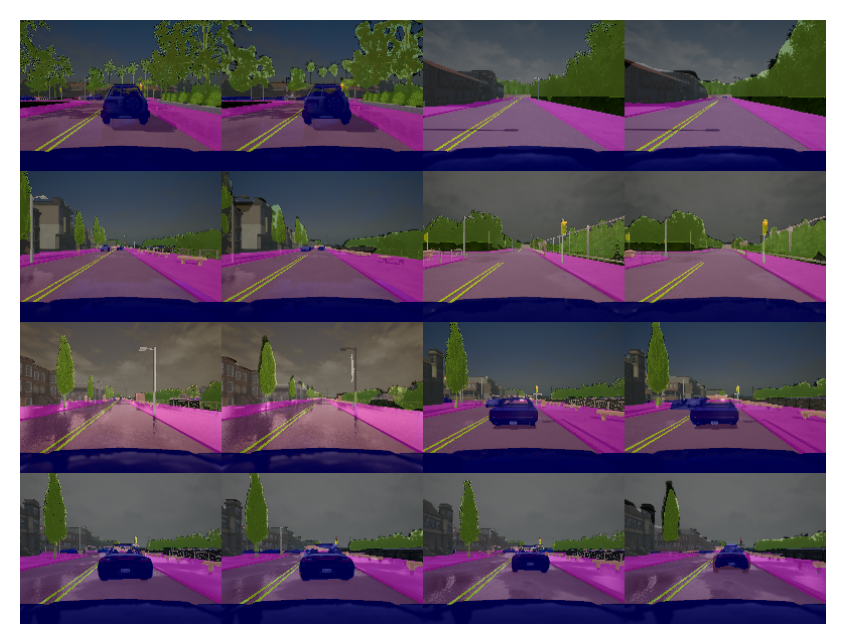

In [ ]:
plt.figure(dpi=200)
plt.imshow(res)
plt.axis('off')
plt.savefig('res.png')

In [ ]:
def results(img1, img2):
  intersection = np.logical_and(img1,img2)
  union = np.logical_or(img1,img2)
  all_pixels = img1.sum() + img2.sum()
  dice = 2*intersection.sum() / all_pixels
  iou = intersection.sum() / union.sum()
  return dice, iou

def scores(y, out):
  channels = out.shape[1]
  classes = out.argmax(axis = 1)
  denominator = y.shape[0] * channels
  dice = 0
  iou = 0
  for val in range(y.shape[0]):
    y_c = F.one_hot(y[val].to(torch.int64),channels).reshape(channels,150,200)
    p_c = F.one_hot(classes[val].to(torch.int64),channels).reshape(channels,150,200)
    for idx in range(channels):
      d, i = results(p_c.cpu().numpy(), y_c.cpu().numpy())
      dice+=d
      iou+=i
  return dice/denominator, iou/denominator

scores(y[...,0],output)

(0.9258729166666656, 0.8638897307062655)

In [ ]:
MODEL.eval()
DICE, IOU = [], [] 
for x,y in TEST_DATASET:
  output = MODEL(x.reshape(32,3,150,200).to(device=DEVICE))
  d, i = scores(y[...,0],output)
  DICE.append(d)
  IOU.append(i)

In [ ]:
np.mean(DICE)

0.9251665658602148

In [ ]:
np.mean(IOU)

0.8628272199474842